In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
import numpy as np
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import col, count, when, round, min, max, avg, sum, countDistinct, when, desc
from pyspark.sql import Window

Esse case é composto de dois datasets no formato csv: ProdutosRetailers.csv e Coletas.csv.

O dataset ProdutosRetailers contém os dados com as informações de produtos e seus fabricantes, bem como dos marketplaces.

Já, o database Coletas.csv contém os dados de coleta de produtos em vários marketplaces diariamente.

CAMPOS:
	
ProdutosRetailer:
	.Customer   - Fabricante do produto
	.Department - Departamento do produto
	.Category   - Categoria do produto
	.Brand      - Marca do produto
	.EAN        - Código de identificação do produto
	.Product    - Nome do produto
	.Retailer   - Nome do marketplace
	.MasterKey_RetailerProduct - Chave que considera o marketplace e o produto

Coletas:
	.DateIns                   - Data de coleta
	.Screenshot                - Screenshot do produto coletado
	.Available                 - Indica se o produto está disponível ou não (1 - disponível; 0 - não disponível)
	.Unavailable               - Indica se o produto não está disponível (1 - não disponível; 0 disponível)
	.SuggestedPrice            - Preço Sugerido de venda para o produto
	.FinalPrice                - Preço de venda coletado no marketplace
	.FromPrice                 - Preço de venda antes do desconto
	.MasterKey_RetailerProduct - Chave que considera o marketplace e o produto


OBJETIVO:

	.Realizar o data cleaning nos dois datasets.
	.Extrair insights.
    .Series Temporais
	.Implementação de modelo de ML (Plus)

dbfs:/FileStore/shared_uploads/kelvin.gprs@hotmail.com/Coletas-1.txt

dbfs:/FileStore/shared_uploads/kelvin.gprs@hotmail.com/ProdutosVarejos-1.txt

In [2]:
spark = SparkSession.builder \
    .appName("Processar Coletas") \
    .getOrCreate()

your 131072x1 screen size is bogus. expect trouble
24/06/04 14:42:07 WARN Utils: Your hostname, kelvin resolves to a loopback address: 127.0.1.1; using 172.24.190.243 instead (on interface eth0)
24/06/04 14:42:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/04 14:42:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
file_path1 = "Coletas.txt"
file_path2 = "ProdutosVarejos.txt"

In [10]:
# Lê o arquivo como DataFrame Spark
df1 = spark.read.option("header", True).csv(file_path1)

In [11]:
df2 = spark.read.option("header", True).csv(file_path2)

In [6]:
df1.printSchema()
df1.show()


root
 |-- DateIns: string (nullable = true)
 |-- Screenshot: string (nullable = true)
 |-- Available: string (nullable = true)
 |-- Unavailable: string (nullable = true)
 |-- SuggestedPrice: string (nullable = true)
 |-- FinalPrice: string (nullable = true)
 |-- MasterKey_RetailerProduct: string (nullable = true)
 |-- RandomPrecosNegativos: string (nullable = true)
 |-- RandomPrecosMissing: string (nullable = true)
 |-- RandomPrecosDiscrepantes: string (nullable = true)
 |-- RandomPrecosDiscrepantesFator: string (nullable = true)

+----------+--------------------+---------+-----------+--------------+------------------+-------------------------+---------------------+-------------------+------------------------+-----------------------------+
|   DateIns|          Screenshot|Available|Unavailable|SuggestedPrice|        FinalPrice|MasterKey_RetailerProduct|RandomPrecosNegativos|RandomPrecosMissing|RandomPrecosDiscrepantes|RandomPrecosDiscrepantesFator|
+----------+--------------------+----

In [6]:
df2.printSchema()
df2.show()


root
 |-- Customer: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Brand: string (nullable = true)
 |-- EAN: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Retailer: string (nullable = true)
 |-- MasterKey_RetailerProduct: string (nullable = true)

+-------------------+-----------+--------------------+-----+----------------+--------------------+----------+-------------------------+
|           Customer| Department|            Category|Brand|             EAN|             Product|  Retailer|MasterKey_RetailerProduct|
+-------------------+-----------+--------------------+-----+----------------+--------------------+----------+-------------------------+
|                 LG|        RAC|Ar Condicionado R...|   LG|   7893299911101|Ar Condicionado S...|    Dufrio|     BRLG7893299911101...|
|                 LG|        W/M|  Lavadoras de Roupa|   LG|       FV3011WG4|LAVADORA SMART LG...|    Dufrio|     BRLGFV

In [8]:
# Selecionar as colunas especificadas
df1_select = df1.select("DateIns", "Available", "SuggestedPrice", "FinalPrice")

# Exibir as primeiras 5 linhas do DataFrame
df1_select.show(5)


+----------+---------+--------------+------------------+
|   DateIns|Available|SuggestedPrice|        FinalPrice|
+----------+---------+--------------+------------------+
|2023-06-25|        1|           0.0|              12.9|
|2023-06-26|        1|           0.0|57.959862449727105|
|2023-06-27|        1|           0.0|              12.9|
|2023-06-28|        1|           0.0| 63.08862112075178|
|2023-06-29|        1|           0.0|              12.9|
+----------+---------+--------------+------------------+
only showing top 5 rows



In [9]:
df1_select2 = df1.select("Available", "SuggestedPrice", "FinalPrice", "RandomPrecosNegativos","RandomPrecosMissing","RandomPrecosDiscrepantes","RandomPrecosDiscrepantesFator" )
df1_select2.show(5)

+---------+--------------+------------------+---------------------+-------------------+------------------------+-----------------------------+
|Available|SuggestedPrice|        FinalPrice|RandomPrecosNegativos|RandomPrecosMissing|RandomPrecosDiscrepantes|RandomPrecosDiscrepantesFator|
+---------+--------------+------------------+---------------------+-------------------+------------------------+-----------------------------+
|        1|           0.0|              12.9|                    1|                1.0|                       0|                          1.0|
|        1|           0.0|57.959862449727105|                    1|                1.0|                       1|            4.493012593002101|
|        1|           0.0|              12.9|                    1|                1.0|                       0|                          1.0|
|        1|           0.0| 63.08862112075178|                    1|                1.0|                       1|            4.890590784554401|

JUNTANDO AS DUAS TABELAS

In [12]:
df_join = df1.join(df2, "MasterKey_RetailerProduct", "inner")

# Exibir as primeiras linhas do DataFrame resultante do join
df_join.show(5)

+-------------------------+----------+--------------------+---------+-----------+--------------+----------+---------------------+-------------------+------------------------+-----------------------------+--------+----------+----------+---------+-------------+--------------------+---------+
|MasterKey_RetailerProduct|   DateIns|          Screenshot|Available|Unavailable|SuggestedPrice|FinalPrice|RandomPrecosNegativos|RandomPrecosMissing|RandomPrecosDiscrepantes|RandomPrecosDiscrepantesFator|Customer|Department|  Category|    Brand|          EAN|             Product| Retailer|
+-------------------------+----------+--------------------+---------+-----------+--------------+----------+---------------------+-------------------+------------------------+-----------------------------+--------+----------+----------+---------+-------------+--------------------+---------+
|     BRAché50004560732...|2023-06-04|https://screensho...|        1|          0|           1.0|    147.99|                    

In [13]:
df_join = df_join.drop("Screenshot", "Unavailable")
df_join.show(5)


+-------------------------+----------+---------+--------------+----------+---------------------+-------------------+------------------------+-----------------------------+--------+----------+----------+---------+-------------+--------------------+---------+
|MasterKey_RetailerProduct|   DateIns|Available|SuggestedPrice|FinalPrice|RandomPrecosNegativos|RandomPrecosMissing|RandomPrecosDiscrepantes|RandomPrecosDiscrepantesFator|Customer|Department|  Category|    Brand|          EAN|             Product| Retailer|
+-------------------------+----------+---------+--------------+----------+---------------------+-------------------+------------------------+-----------------------------+--------+----------+----------+---------+-------------+--------------------+---------+
|     BRAché50004560732...|2023-06-04|        1|           1.0|    147.99|                    1|                1.0|                       0|                          1.0|    Aché| EDISTRIDE|PRESCRIÇÃO|EDISTRIDE|5000456073240|

In [9]:
# Listar todas as colunas disponíveis no DataFrame resultante do join
df_join.columns


['MasterKey_RetailerProduct',
 'DateIns',
 'Available',
 'SuggestedPrice',
 'FinalPrice',
 'RandomPrecosNegativos',
 'RandomPrecosMissing',
 'RandomPrecosDiscrepantes',
 'RandomPrecosDiscrepantesFator',
 'Customer',
 'Department',
 'Category',
 'Brand',
 'EAN',
 'Product',
 'Retailer']

In [13]:
# Verificar a quantidade de valores nulos nas colunas especificadas
df_join.select([count(when(col(c).isNull(), c)).alias(c) for c in ["Available", "SuggestedPrice", "FinalPrice", "RandomPrecosNegativos", "RandomPrecosMissing", "RandomPrecosDiscrepantes", "RandomPrecosDiscrepantesFator"]]).show()


+---------+--------------+----------+---------------------+-------------------+------------------------+-----------------------------+
|Available|SuggestedPrice|FinalPrice|RandomPrecosNegativos|RandomPrecosMissing|RandomPrecosDiscrepantes|RandomPrecosDiscrepantesFator|
+---------+--------------+----------+---------------------+-------------------+------------------------+-----------------------------+
|        0|         16459|   3719314|                    0|             686820|                       0|                            0|
+---------+--------------+----------+---------------------+-------------------+------------------------+-----------------------------+



In [14]:
total_rows = df_join.count()
print("Número total de linhas no DataFrame df_join:", total_rows)


Número total de linhas no DataFrame df_join: 6880169


Então podemos deletar a coluna RandomPrecosMissing, pois a quantidade de nulos é muito grande 

In [14]:
df_join = df_join.drop("RandomPrecosMissing")
df_join.show(5)

+-------------------------+----------+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+---------+-------------+--------------------+---------+
|MasterKey_RetailerProduct|   DateIns|Available|SuggestedPrice|FinalPrice|RandomPrecosNegativos|RandomPrecosDiscrepantes|RandomPrecosDiscrepantesFator|Customer|Department|  Category|    Brand|          EAN|             Product| Retailer|
+-------------------------+----------+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+---------+-------------+--------------------+---------+
|     BRAché50004560732...|2023-06-04|        1|           1.0|    147.99|                    1|                       0|                          1.0|    Aché| EDISTRIDE|PRESCRIÇÃO|EDISTRIDE|5000456073240|EDISTRIDE 10MG CO...|DrogaRaia|
|     BRAché50004560732...|2023-06-05|        1|

DELETAR AS COLUNAS QUE NAO IRA UTILIZAR

In [15]:
df_join = df_join.drop("EAN","MasterKey_RetailerProduct")

In [20]:
df_join.show(5)

+----------+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+---------+--------------------+
|   DateIns|Available|SuggestedPrice|FinalPrice|RandomPrecosNegativos|RandomPrecosDiscrepantes|RandomPrecosDiscrepantesFator|Customer|Department|  Category|    Brand|             Product|
+----------+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+---------+--------------------+
|2023-06-04|        1|           1.0|    147.99|                    1|                       0|                          1.0|    Aché| EDISTRIDE|PRESCRIÇÃO|EDISTRIDE|EDISTRIDE 10MG CO...|
|2023-06-05|        1|           1.0|    147.99|                    1|                       0|                          1.0|    Aché| EDISTRIDE|PRESCRIÇÃO|EDISTRIDE|EDISTRIDE 10MG CO...|
|2023-06-06|        1|           1.0|    147.99|            

DATA


In [16]:
df_join = df_join.withColumn("Ano", year("DateIns")) \
                 .withColumn("Mês", month("DateIns")) \
                 .withColumn("Dia", dayofmonth("DateIns"))

df_join = df_join.drop("DateIns")
df_join.show()

+---------+--------------+-----------------+---------------------+------------------------+-----------------------------+--------+----------+----------+---------+--------------------+---------+----+---+---+
|Available|SuggestedPrice|       FinalPrice|RandomPrecosNegativos|RandomPrecosDiscrepantes|RandomPrecosDiscrepantesFator|Customer|Department|  Category|    Brand|             Product| Retailer| Ano|Mês|Dia|
+---------+--------------+-----------------+---------------------+------------------------+-----------------------------+--------+----------+----------+---------+--------------------+---------+----+---+---+
|        1|           1.0|           147.99|                    1|                       0|                          1.0|    Aché| EDISTRIDE|PRESCRIÇÃO|EDISTRIDE|EDISTRIDE 10MG CO...|DrogaRaia|2023|  6|  4|
|        1|           1.0|           147.99|                    1|                       0|                          1.0|    Aché| EDISTRIDE|PRESCRIÇÃO|EDISTRIDE|EDISTRIDE 

Ter apenas 2 números depois do ponto [FinalPrice, RandomPrecosDiscrepantesFator

In [17]:
df_join = df_join.withColumn("FinalPrice", round(col("FinalPrice"), 2)) \
                 .withColumn("RandomPrecosDiscrepantesFator", round(col("RandomPrecosDiscrepantesFator"), 1))

df_join.show()

+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+---------+--------------------+---------+----+---+---+
|Available|SuggestedPrice|FinalPrice|RandomPrecosNegativos|RandomPrecosDiscrepantes|RandomPrecosDiscrepantesFator|Customer|Department|  Category|    Brand|             Product| Retailer| Ano|Mês|Dia|
+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+---------+--------------------+---------+----+---+---+
|        1|           1.0|    147.99|                    1|                       0|                          1.0|    Aché| EDISTRIDE|PRESCRIÇÃO|EDISTRIDE|EDISTRIDE 10MG CO...|DrogaRaia|2023|  6|  4|
|        1|           1.0|    147.99|                    1|                       0|                          1.0|    Aché| EDISTRIDE|PRESCRIÇÃO|EDISTRIDE|EDISTRIDE 10MG CO...|DrogaRaia|2023|  6|  5|


In [23]:
df_join.orderBy(col("Ano").asc()).show(10)


+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+---------+--------------------+----+---+---+
|Available|SuggestedPrice|FinalPrice|RandomPrecosNegativos|RandomPrecosDiscrepantes|RandomPrecosDiscrepantesFator|Customer|Department|  Category|    Brand|             Product| Ano|Mês|Dia|
+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+---------+--------------------+----+---+---+
|        1|           1.0|    147.99|                    1|                       0|                          1.0|    Aché| EDISTRIDE|PRESCRIÇÃO|EDISTRIDE|EDISTRIDE 10MG CO...|2023|  6|  4|
|        1|           1.0|     63.07|                    1|                       0|                          1.0|    Aché|     CORUS|PRESCRIÇÃO|    CORUS|CORUS H 50/12,5MG...|2023|  5|  7|
|        1|           1.0|      NULL|             

In [25]:
quantidade_produtos_distintos = df_join.select(countDistinct("Product")).first()[0]
print("Quantidade de produtos distintos:", quantidade_produtos_distintos)

24/06/02 22:08:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:08:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:08:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:08:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:08:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:08:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:08:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:08:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Quantidade de produtos distintos: 1978


# Resumo dos Dados

Temos um conjunto de dados para o ano de 2023, começando em Maio e termina em junho, que contém informações sobre produtos de varejistas em marketplaces. Estes dados incluem o preço final dos produtos, e algumas empresas de marketplace vendem o mesmo produto com preços diferentes. Além disso, precisamos identificar o estoque disponível desses produtos, temos 375 marcas diferentes e 1978 produtos diferentes.

Proximos passos, para a coluna SuggestedPrice substituir os numeros faltantes pela moda, por cada produto & ver remover outilers 

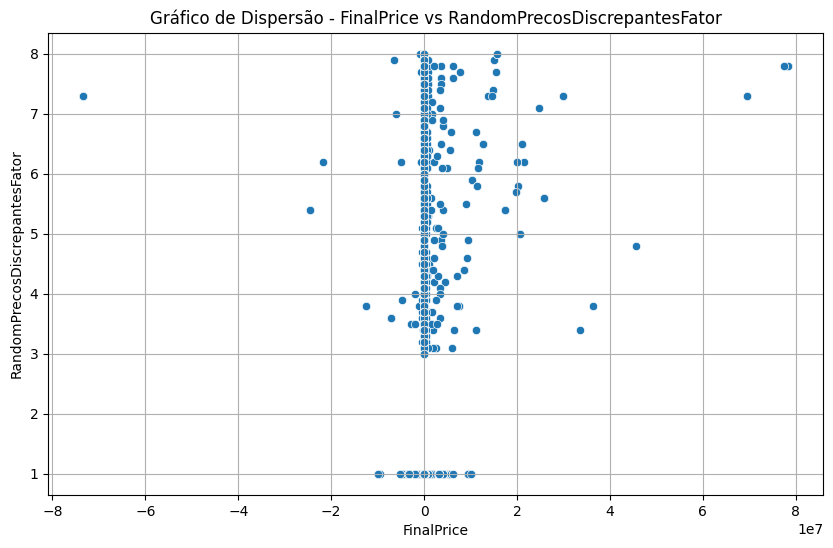

In [27]:
df_pandas = df_join.select("FinalPrice", "RandomPrecosDiscrepantesFator").toPandas()

# Criar o gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(x="FinalPrice", y="RandomPrecosDiscrepantesFator", data=df_pandas)
plt.title("Gráfico de Dispersão - FinalPrice vs RandomPrecosDiscrepantesFator")
plt.xlabel("FinalPrice")
plt.ylabel("RandomPrecosDiscrepantesFator")
plt.grid(True)
plt.show()

In [13]:
df_join2 = df_join

In [33]:
# Filtrar as linhas onde 'Brand' seja igual a 'EDISTRIDE' e 'Dia' igual a 9 e 'Mês' igual a 6
edistride_rows = df_join2.filter((df_join2["Brand"] == "EDISTRIDE") &
                                 (df_join2["Dia"] == 9) &
                                 (df_join2["Mês"] == 6))\
                         .orderBy(desc("FinalPrice"))

# Mostrar as linhas
edistride_rows.show()

+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+---------+--------------------+----+---+---+
|Available|SuggestedPrice|FinalPrice|RandomPrecosNegativos|RandomPrecosDiscrepantes|RandomPrecosDiscrepantesFator|Customer|Department|  Category|    Brand|             Product| Ano|Mês|Dia|
+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+---------+--------------------+----+---+---+
|        1|           1.0|   1080.03|                    1|                       1|                          6.5|    Aché| EDISTRIDE|PRESCRIÇÃO|EDISTRIDE|EDISTRIDE 10MG CO...|2023|  6|  9|
|        1|           1.0|    726.69|                    1|                       1|                          3.8|    Aché| EDISTRIDE|PRESCRIÇÃO|EDISTRIDE|EDISTRIDE 10MG CO...|2023|  6|  9|
|        1|           1.0|    638.31|             

In [ ]:
df_result = df_join

In [34]:
edistride_rows = df_result.filter((df_result["Brand"] == "EDISTRIDE") &
                                  (df_result["Dia"] == 9) &
                                  (df_result["Mês"] == 6))\
                          .orderBy(desc("FinalPrice"))

# Mostrar as linhas (limitar a 20 linhas)
edistride_rows.show(20)

24/06/02 22:10:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:10:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:10:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:10:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:10:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:10:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:10:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:10:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:10:24 WARN RowBasedKeyValueBatch: Calling spill() on

+--------------------+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+---------+----+---+---+
|             Product|Available|SuggestedPrice|FinalPrice|RandomPrecosNegativos|RandomPrecosDiscrepantes|RandomPrecosDiscrepantesFator|Customer|Department|  Category|    Brand| Ano|Mês|Dia|
+--------------------+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+---------+----+---+---+
|EDISTRIDE 10MG CO...|        0|           1.0| 223722.06|                    1|                       0|                          1.0|    Aché| EDISTRIDE|PRESCRIÇÃO|EDISTRIDE|2023|  6|  9|
|EDISTRIDE 10MG CO...|        1|           1.0| 223722.06|                    1|                       0|                          1.0|    Aché| EDISTRIDE|PRESCRIÇÃO|EDISTRIDE|2023|  6|  9|
|EDISTRIDE 10MG CO...|        0|           1.0| 22

Dessa forma, não podemos substitur pela Moda


In [37]:
# Contar a quantidade de valores nulos na coluna 'FinalPrice'
null_finalprice_count = df_result.filter(df_result["FinalPrice"].isNull()).count()

# Mostrar a quantidade de valores nulos
print(f"Quantidade de valores nulos na coluna 'FinalPrice': {null_finalprice_count}")


24/06/02 22:11:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:11:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:11:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:11:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:11:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:11:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:11:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:11:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:11:25 WARN RowBasedKeyValueBatch: Calling spill() on

Quantidade de valores nulos na coluna 'FinalPrice': 3719314


In [39]:
# Contar a quantidade de valores nulos na coluna 'FinalPrice'
null_finalprice_count1 = df_result.filter(df_result["FinalPrice"].isNull()).count()

# Mostrar a quantidade de valores nulos
print(f"Quantidade de valores nulos na coluna 'FinalPrice': {null_finalprice_count1}")


24/06/02 22:14:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:14:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:14:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:14:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:14:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:14:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:14:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:14:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:14:22 WARN RowBasedKeyValueBatch: Calling spill() on

Quantidade de valores nulos na coluna 'FinalPrice': 355443


In [40]:
# Filtrar as linhas onde 'RandomPrecosDiscrepantesFator' é maior que 1
discrepant_prices = df_result.filter(df_result["RandomPrecosDiscrepantesFator"] > 1)

# Mostrar as linhas (limitar a 20 linhas)
discrepant_prices.show(20)


24/06/02 22:17:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:17:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:17:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:17:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:17:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:17:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:17:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:17:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:17:21 WARN RowBasedKeyValueBatch: Calling spill() on

+--------------------+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+---------+----+---+---+
|             Product|Available|SuggestedPrice|FinalPrice|RandomPrecosNegativos|RandomPrecosDiscrepantes|RandomPrecosDiscrepantesFator|Customer|Department|  Category|    Brand| Ano|Mês|Dia|
+--------------------+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+---------+----+---+---+
|EDISTRIDE 10MG CO...|        1|           1.0|    645.93|                    1|                       1|                          4.4|    Aché| EDISTRIDE|PRESCRIÇÃO|EDISTRIDE|2023|  6| 27|
|EDISTRIDE 10MG CO...|        1|           1.0|    645.93|                    1|                       1|                          4.4|    Aché| EDISTRIDE|PRESCRIÇÃO|EDISTRIDE|2023|  6| 27|
|EDISTRIDE 10MG CO...|        1|           1.0|   

tentativa

Todas as linhas ser igual a min do produto agrupada pelo Product e multiplicada e eliminar outilier onde RandomPrecosDiscrepantes = 1 for muito alto

In [42]:
# Contar a quantidade de linhas onde 'RandomPrecosNegativos' é igual a 1
random_precos_negativos_count = df_result.filter(df_result["RandomPrecosNegativos"] == -1).count()

# Mostrar a quantidade de linhas
print(f"Quantidade de linhas onde 'RandomPrecosNegativos' é igual a 1: {random_precos_negativos_count}")


24/06/02 22:19:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:19:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:19:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:19:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:19:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:19:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:19:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:19:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:19:26 WARN RowBasedKeyValueBatch: Calling spill() on

Quantidade de linhas onde 'RandomPrecosNegativos' é igual a 1: 115303794


In [44]:
# Filtrar as linhas onde 'Product' contém a substring 'EDISTRIDE 10MG' e o dia é 9 e o mês é 6 usando like
edistride_rows_like = df_result.filter(
    (df_result["Product"].like("%EDISTRIDE 10MG%")) &
    (df_result["Dia"] == 9) &
    (df_result["Mês"] == 6)
)

# Mostrar as linhas (limitar a 20 linhas)
edistride_rows_like.show(50)


24/06/02 22:19:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:19:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:19:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:19:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:19:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:19:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:19:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:19:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+--------------------+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+---------+----+---+---+
|             Product|Available|SuggestedPrice|FinalPrice|RandomPrecosNegativos|RandomPrecosDiscrepantes|RandomPrecosDiscrepantesFator|Customer|Department|  Category|    Brand| Ano|Mês|Dia|
+--------------------+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+---------+----+---+---+
|EDISTRIDE 10MG CO...|        1|           1.0|      NULL|                    1|                       0|                          1.0|    Aché| EDISTRIDE|PRESCRIÇÃO|EDISTRIDE|2023|  6|  9|
|EDISTRIDE 10MG CO...|        1|           1.0| 223722.06|                    1|                       0|                          1.0|    Aché| EDISTRIDE|PRESCRIÇÃO|EDISTRIDE|2023|  6|  9|
|EDISTRIDE 10MG CO...|        1|           1.0|   

In [45]:
# Filtrar as linhas onde 'Product' contém a substring 'EDISTRIDE 10MG' e o dia é 9 e o mês é 6, e 'FinalPrice' é nulo
edistride_rows_like = df_result.filter(
    (df_result["Product"].like("%EDISTRIDE 10MG%")) &
    (df_result["Dia"] == 9) &
    (df_result["Mês"] == 6) &
    (df_result["FinalPrice"] == 223722.06)
)

# Mostrar as linhas (limitar a 50 linhas)
edistride_rows_like.show(50)

24/06/02 22:20:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:20:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:20:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:20:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:20:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:20:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:20:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:20:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+--------------------+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+---------+----+---+---+
|             Product|Available|SuggestedPrice|FinalPrice|RandomPrecosNegativos|RandomPrecosDiscrepantes|RandomPrecosDiscrepantesFator|Customer|Department|  Category|    Brand| Ano|Mês|Dia|
+--------------------+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+---------+----+---+---+
|EDISTRIDE 10MG CO...|        1|           1.0| 223722.06|                    1|                       0|                          1.0|    Aché| EDISTRIDE|PRESCRIÇÃO|EDISTRIDE|2023|  6|  9|
|EDISTRIDE 10MG CO...|        0|           1.0| 223722.06|                    1|                       0|                          1.0|    Aché| EDISTRIDE|PRESCRIÇÃO|EDISTRIDE|2023|  6|  9|
|EDISTRIDE 10MG CO...|        0|           1.0| 22

In [46]:
# Filtrar as linhas onde 'Product' contém a substring 'EDISTRIDE 10MG' e o dia é 9 e o mês é 6, e 'FinalPrice' é nulo
edistride_rows_like = df_result.filter(
    (df_result["Product"].like("%EDISTRIDE 10MG%")) &
    (df_result["Dia"] == 9) &
    (df_result["Mês"] == 6) &
    (df_result["FinalPrice"].isNull())
)

# Mostrar as linhas (limitar a 50 linhas)
edistride_rows_like.show(50)


24/06/02 22:20:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:20:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:20:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:20:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:20:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:20:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:20:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 22:20:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+--------------------+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+---------+----+---+---+
|             Product|Available|SuggestedPrice|FinalPrice|RandomPrecosNegativos|RandomPrecosDiscrepantes|RandomPrecosDiscrepantesFator|Customer|Department|  Category|    Brand| Ano|Mês|Dia|
+--------------------+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+---------+----+---+---+
|EDISTRIDE 10MG CO...|        1|           1.0|      NULL|                    1|                       0|                          1.0|    Aché| EDISTRIDE|PRESCRIÇÃO|EDISTRIDE|2023|  6|  9|
|EDISTRIDE 10MG CO...|        0|           1.0|      NULL|                    1|                       0|                          1.0|    Aché| EDISTRIDE|PRESCRIÇÃO|EDISTRIDE|2023|  6|  9|
|EDISTRIDE 10MG CO...|        0|           1.0|   

A ideia do min nao é mais interessante pois o RandomPrecosDiscrepantesFator não acompanha realmente a mudança
Volta para mudança da moda e retirada dos outilers

# SUBSTITUIR OUTILERS E NULL PARA MEDIANA

In [39]:
df_join.printSchema()


root
 |-- Available: string (nullable = true)
 |-- SuggestedPrice: string (nullable = true)
 |-- FinalPrice: float (nullable = true)
 |-- RandomPrecosNegativos: string (nullable = true)
 |-- RandomPrecosMissing: string (nullable = true)
 |-- RandomPrecosDiscrepantes: string (nullable = true)
 |-- RandomPrecosDiscrepantesFator: double (nullable = true)
 |-- Customer: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Ano: integer (nullable = true)
 |-- Mês: integer (nullable = true)
 |-- Dia: integer (nullable = true)



In [16]:
from pyspark.sql.types import FloatType

# Convertendo a coluna FinalPrice para FloatType
df_join = df_join.withColumn("FinalPrice", df_join["FinalPrice"].cast(FloatType()))


In [27]:
df_join.printSchema()

root
 |-- Available: string (nullable = true)
 |-- SuggestedPrice: string (nullable = true)
 |-- FinalPrice: float (nullable = true)
 |-- RandomPrecosNegativos: string (nullable = true)
 |-- RandomPrecosDiscrepantes: string (nullable = true)
 |-- RandomPrecosDiscrepantesFator: double (nullable = true)
 |-- Customer: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Retailer: string (nullable = true)
 |-- Ano: integer (nullable = true)
 |-- Mês: integer (nullable = true)
 |-- Dia: integer (nullable = true)



In [18]:
from pyspark.sql.functions import pandas_udf, PandasUDFType
import pandas as pd

# Definir a função para substituir os valores 'NULL' pela mediana dentro de cada grupo
@pandas_udf(df_join.schema, PandasUDFType.GROUPED_MAP)
def replace_null_with_median(pdf):
    median_finalprice = pdf['FinalPrice'].median()
    pdf['FinalPrice'] = pdf['FinalPrice'].fillna(median_finalprice)
    return pdf

# Aplicar a função para cada grupo de produto
df_join_with_median = df_join.groupby("Product").apply(replace_null_with_median)

# Mostrar o DataFrame com valores 'NULL' substituídos pela mediana por grupo de produto
df_join_with_median.show()


/home/kelvin/.local/lib/python3.10/site-packages/pyspark/sql/pandas/group_ops.py:104: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+-------------+--------------------+--------------------+----+---+---+
|Available|SuggestedPrice|FinalPrice|RandomPrecosNegativos|RandomPrecosDiscrepantes|RandomPrecosDiscrepantesFator|Customer|Department|  Category|        Brand|             Product|            Retailer| Ano|Mês|Dia|
+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+-------------+--------------------+--------------------+----+---+---+
|        1|         24.59|     33.76|                    1|                       0|                          1.0|   Seara|       Alp|Congelados|Seara Gourmet|100% Vegetal burg...|Ifood - Forte Sup...|2023|  6| 18|
|        1|         24.59|     33.76|                    1|                       0|                          1.0|   Seara|       Alp|Congel

/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [22]:
edistride_rows_like1 = df_join_with_median.filter(
    (df_join_with_median["Product"].like("%100% Vegetal burg%"))
     # &
   # (df_join["Dia"] == 9) &
   # (df_join["Mês"] == 6)
)

edistride_rows_like1.show(50)


+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+-------------+--------------------+--------------------+----+---+---+
|Available|SuggestedPrice|FinalPrice|RandomPrecosNegativos|RandomPrecosDiscrepantes|RandomPrecosDiscrepantesFator|Customer|Department|  Category|        Brand|             Product|            Retailer| Ano|Mês|Dia|
+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+-------------+--------------------+--------------------+----+---+---+
|        1|         24.59|     33.76|                    1|                       0|                          1.0|   Seara|       Alp|Congelados|Seara Gourmet|100% Vegetal burg...|Ifood - Forte Sup...|2023|  6| 18|
|        1|         24.59|     33.76|                    1|                       0|                          1.0|   Seara|       Alp|Congel

In [23]:
edistride_rows_like3 = df_join.filter(
    (df_join["Product"].like("%100% Vegetal burg%"))
     # &
   # (df_join["Dia"] == 9) &
   # (df_join["Mês"] == 6)
)

edistride_rows_like3.show(50)


+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+-------------+--------------------+--------------------+----+---+---+
|Available|SuggestedPrice|FinalPrice|RandomPrecosNegativos|RandomPrecosDiscrepantes|RandomPrecosDiscrepantesFator|Customer|Department|  Category|        Brand|             Product|            Retailer| Ano|Mês|Dia|
+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+----------+-------------+--------------------+--------------------+----+---+---+
|        1|         24.59|     33.76|                    1|                       0|                          1.0|   Seara|       Alp|Congelados|Seara Gourmet|100% Vegetal burg...|Ifood - Forte Sup...|2023|  6| 18|
|        1|         24.59|     33.76|                    1|                       0|                          1.0|   Seara|       Alp|Congel

In [20]:
df_mediana = df_join_with_median

In [21]:
df_mediana.printSchema()

root
 |-- Available: string (nullable = true)
 |-- SuggestedPrice: string (nullable = true)
 |-- FinalPrice: float (nullable = true)
 |-- RandomPrecosNegativos: string (nullable = true)
 |-- RandomPrecosDiscrepantes: string (nullable = true)
 |-- RandomPrecosDiscrepantesFator: double (nullable = true)
 |-- Customer: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Retailer: string (nullable = true)
 |-- Ano: integer (nullable = true)
 |-- Mês: integer (nullable = true)
 |-- Dia: integer (nullable = true)



In [25]:
null_counts = df_mediana.select([(sum(col(c).isNull().cast("int")).alias(c)) for c in df_mediana.columns])

# Mostrar o resultado
null_counts.show()

/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.n

+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+--------+-----+-------+--------+---+---+---+
|Available|SuggestedPrice|FinalPrice|RandomPrecosNegativos|RandomPrecosDiscrepantes|RandomPrecosDiscrepantesFator|Customer|Department|Category|Brand|Product|Retailer|Ano|Mês|Dia|
+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+--------+-----+-------+--------+---+---+---+
|        0|         16459|    355443|                    0|                       0|                            0|       0|         0|       0| 4615|      0|       0|  0|  0|  0|
+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+--------+-----+-------+--------+---+---+---+



In [26]:
null_counts2 = df_join.select([(sum(col(c).isNull().cast("int")).alias(c)) for c in df_join.columns])

# Mostrar o resultado
null_counts2.show()

+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+--------+-----+-------+--------+---+---+---+
|Available|SuggestedPrice|FinalPrice|RandomPrecosNegativos|RandomPrecosDiscrepantes|RandomPrecosDiscrepantesFator|Customer|Department|Category|Brand|Product|Retailer|Ano|Mês|Dia|
+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+--------+-----+-------+--------+---+---+---+
|        0|         16459|   3719314|                    0|                       0|                            0|       0|         0|       0| 4615|      0|       0|  0|  0|  0|
+---------+--------------+----------+---------------------+------------------------+-----------------------------+--------+----------+--------+-----+-------+--------+---+---+---+



# Separando a Amostra

In [26]:
total_products = df_mediana.select(countDistinct("Product")).collect()[0][0]
total_Category = df_mediana.select(countDistinct("Category")).collect()[0][0]
total_Marketplace = df_mediana.select(countDistinct("Retailer")).collect()[0][0]
total_Fabrica = df_mediana.select(countDistinct("Customer")).collect()[0][0]
print("Total de produtos:", total_products)
print("Total de categoria:", total_Category)
print("Total de empresas de varejo marketplace:", total_Marketplace)
print("Total de fabrica:", total_Fabrica )


/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.n

Total de produtos: 1978
Total de categoria: 57
Total de empresas de varejo marketplace: 120
Total de fabrica: 4


/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [27]:
fabrica_counts = df_mediana.groupBy("Customer").agg(count("*").alias("Total_Linhas"))

# Mostrar os resultados
print("Contagem de linhas por fabricante:")
fabrica_counts.show()

Contagem de linhas por fabricante:


/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.n

+----------+------------+
|  Customer|Total_Linhas|
+----------+------------+
|  Unilever|     3437255|
|      Aché|     1504830|
|Beiersdorf|      730716|
|     Seara|     1207368|
+----------+------------+



/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [31]:
categoria_counts_por_empresa = df_mediana.groupBy("Customer", "Category").agg(count("*").alias("Total_Linhas"))

# Ordenar os resultados do maior para o menor
categoria_counts_por_empresa_ordernada = categoria_counts_por_empresa.orderBy(desc("Total_Linhas"))

# Mostrar os resultados
print("Contagem de linhas por categoria em cada empresa de varejo marketplace (ordenado do maior para o menor):")
categoria_counts_por_empresa_ordernada.show()

Contagem de linhas por categoria em cada empresa de varejo marketplace (ordenado do maior para o menor):


/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.n

+----------+-----------------+------------+
|  Customer|         Category|Total_Linhas|
+----------+-----------------+------------+
|  Unilever|       DEODORANTS|      769027|
|  Unilever|             HAIR|      756013|
|      Aché|       PRESCRIÇÃO|      666507|
|     Seara|       Congelados|      588584|
|  Unilever|    PERSONAL WASH|      399062|
|      Aché|        GENÉRICOS|      385398|
|  Unilever|DRESSINGS - LOCAL|      224663|
|  Unilever|         FABCLEAN|      183549|
|  Unilever|           Outros|      180309|
|  Unilever|         NATURAIS|      163724|
|      Aché|              MIP|      161406|
|Beiersdorf|              Deo|      149544|
|     Seara|           Suínos|      144448|
|Beiersdorf|        Face Care|      137558|
|  Unilever|             Baby|      134993|
|      Aché|  DERMOCOSMÉTICOS|      120231|
|  Unilever|        ORAL CARE|      115717|
|     Seara|        Embutidos|      113216|
|     Seara|            Frios|      113216|
|  Unilever|           FABCON|  

/home/kelvin/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
